In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network

## Template 03
## FIFA dataset 

<img src='../../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [4]:
import os
import datetime
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#from utils.log_event import fn_log_event


# verify if the directory exists
def fn_dir_exists(_dir):
    '''
    Args:
    	_dir: path if a directory
     '''

    res = os.path.exists(_dir)

    fn_log_event ('-- Directory "{}" exist : {}'.format(_dir, res), 'debug')

    if not res:

        fn_log_event ('-- Directory "{}" does not exists.'.format(_dir), 'debug')

        sys.exit('-- Directory "{}" does not exists.'.format(_dir))

    return res



def fn_file_exists(_file):
    '''
        verify if the file exists
    '''
    res = os.path.exists(_file)

    fn_log_event ('-- File "{}" exist : {}'.format(_file, res), 'debug')

    if not res:

        fn_log_event ('-- File "{}" does not exists.'.format(_file), 'debug')

        sys.exit('-- File "{}" does not exists.'.format(_file))

    return res
    
    
###-----------------------------    
### Verify or create a directory
###-----------------------------    
def fn_verify_dir(_path : str):
    '''
    Arg:
        path: path to verify the directory
    returns:
        create dir if it does not exists
    '''
    if os.path.exists(_path): # check if the path exists. Maybe a file or a folder
        
        print(_path, ' exists') # advised the user
        
    else:
        
        os.makedirs(_path) # create the path
        
        print("Created folder : ", _path)
        
###------------------------------------------------
### Plot Loss Curve using Tensorflow history object
###------------------------------------------------
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    


###------------------------------
### Plot Loss Curve using pytorch
###------------------------------
def fn_plot_torch_hist(hist_df):
    
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset=y2)
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot
        
    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()


    
###---------------------------------------------------    
### Plot count of classes in training and testing sets
###---------------------------------------------------    
def fn_plot_labels(tr_ds, ts_ds, class_names = None):
    
    '''
        Args:
            tr_ds :  Training Dataset
            ts_ds : Testing dataset
        Returns : none
    '''

    # create figure and axes
    fig, axes = plt.subplots(1,2, figsize = (15,5))
    
    # get names of the classes
    if not class_names:
        tr_class_names = tr_ds.class_names
        ts_class_names = tr_ds.class_names

    # pick first axis
    ax = axes[0]

    # create dict of training labels
    class_counts = {}
    for imgs, lbls in tr_ds:
        for lbl in lbls.numpy():
            class_counts[lbl] = class_counts.get(lbl, 0) +1 
    
    # bar plot
    ax.bar(tr_class_names, [class_counts.get(i, 0) for i in range(len(tr_class_names))],
           align='center',color = 'DarkBlue', alpha = 0.7)
    
    # add title
    ax.set_title('Training Set')
        
    # grids make it look good
    ax.grid()


    #pick second image
    ax = axes[1]

    # create dict of training labels
    class_counts = {}
    for imgs, lbls in ts_ds:
        for lbl in lbls.numpy():
            class_counts[lbl] = class_counts.get(lbl, 0) +1 
    
    # bar plot
    ax.bar(ts_class_names, [class_counts.get(i, 0) for i in range(len(ts_class_names))],
           align='center',color = 'orange', alpha = 0.7)
    
    # add title
    ax.set_title('Test Set')
    

    # grids make it look good
    ax.grid()
    
    # fit the subplot(s) in to the figure area
    plt.tight_layout()
    
    # display all open figures
    plt.show()

def fn_convert_timestamp(tstr):
    '''
        Function to conver string of form "2015-11-12 1444"
    '''
    
    return datetime.strptime(tstr, "%Y-%m-%d_%H%M")

###----------------------
### Plot confusion matrix
###----------------------
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();


In [5]:
###----------------------
### Some basic parameters
###----------------------

inpDir = 'D:\DNN\input'
outDir = '../output'
modelDir = 'D:\DNN\models'
subDir = 'weather'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 20 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'medium',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

## Read weather data set

In [6]:
data_df = pd.read_csv(os.path.join(inpDir, 'weatherHistory.csv'))
data_df.shape

(96453, 12)

In [7]:
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [8]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'], utc = True)
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,datetime
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.,2006-03-31 22:00:00+00:00
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.,2006-03-31 23:00:00+00:00
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.,2006-04-01 00:00:00+00:00
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.,2006-04-01 01:00:00+00:00
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.,2006-04-01 02:00:00+00:00


In [9]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            96453 non-null  object             
 1   Summary                   96453 non-null  object             
 2   Precip Type               95936 non-null  object             
 3   Temperature (C)           96453 non-null  float64            
 4   Apparent Temperature (C)  96453 non-null  float64            
 5   Humidity                  96453 non-null  float64            
 6   Wind Speed (km/h)         96453 non-null  float64            
 7   Wind Bearing (degrees)    96453 non-null  float64            
 8   Visibility (km)           96453 non-null  float64            
 9   Loud Cover                96453 non-null  float64            
 10  Pressure (millibars)      96453 non-null  float64            
 11  Daily Summary  

In [10]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature (C),96453.0,11.932678,9.551546,-21.822222,4.688889,12.0000,18.838889,39.905556
Apparent Temperature (C),96453.0,10.855029,10.696847,-27.716667,2.311111,12.0000,18.838889,39.344444
Humidity,96453.0,0.734899,0.195473,0.000000,0.600000,0.7800,0.890000,1.000000
Wind Speed (km/h),96453.0,10.810640,6.913571,0.000000,5.828200,9.9659,14.135800,63.852600
Wind Bearing (degrees),96453.0,187.509232,107.383428,0.000000,116.000000,180.0000,290.000000,359.000000
Visibility (km),96453.0,10.347325,4.192123,0.000000,8.339800,10.0464,14.812000,16.100000
Loud Cover,96453.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
Pressure (millibars),96453.0,1003.235956,116.969906,0.000000,1011.900000,1016.4500,1021.090000,1046.380000


In [11]:
data_df.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary', 'datetime'],
      dtype='object')

In [12]:
num_cols = ['Temperature (C)',   'Apparent Temperature (C)' , 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)',  'Loud Cover',
       'Pressure (millibars)']

len(num_cols)

8

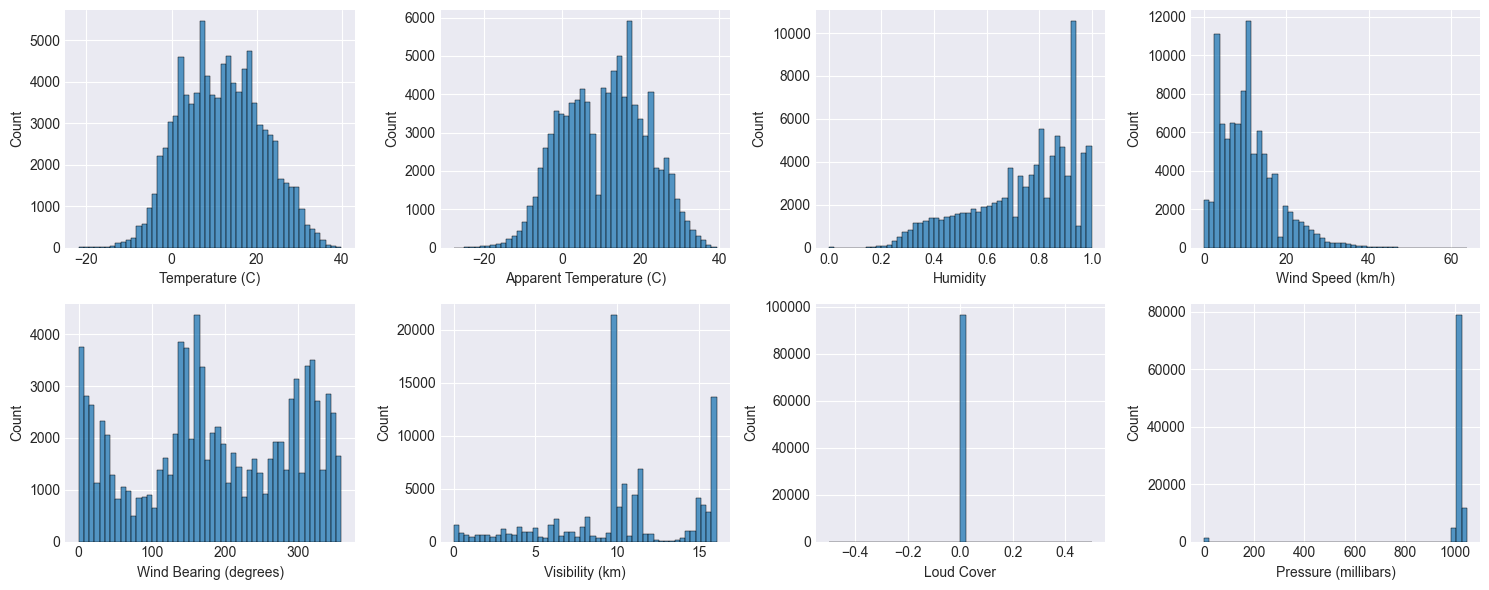

In [13]:

fig , axes = plt.subplots(2,4)

axes = axes.ravel()

for count, col in enumerate(num_cols):
    ax = axes[count]
    sns.histplot(data_df , x = col , ax = ax , bins= 50)

plt.tight_layout()

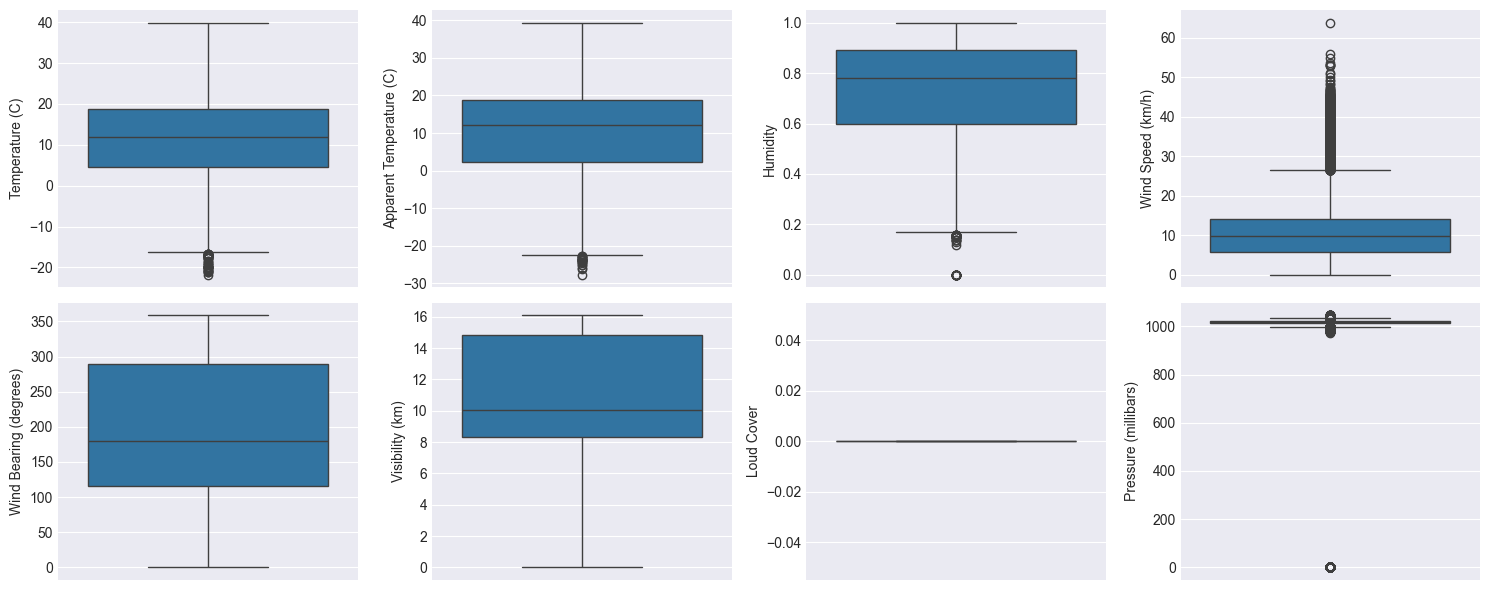

In [14]:

fig , axes = plt.subplots(2,4)

axes = axes.ravel()

for count, col in enumerate(num_cols):
    ax = axes[count]
    sns.boxplot(data=data_df , y = col , ax = ax )

plt.tight_layout()

In [15]:
data_df[num_cols].corr()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
Temperature (C),1.000000,0.992629,-0.632255,0.008957,0.029988,0.392847,NaN,-0.005447
Apparent Temperature (C),0.992629,1.000000,-0.602571,-0.056650,0.029031,0.381718,NaN,-0.000219
Humidity,-0.632255,-0.602571,1.000000,-0.224951,0.000735,-0.369173,NaN,0.005454
Wind Speed (km/h),0.008957,-0.056650,-0.224951,1.000000,0.103822,0.100749,NaN,-0.049263
Wind Bearing (degrees),0.029988,0.029031,0.000735,0.103822,1.000000,0.047594,NaN,-0.011651
Visibility (km),0.392847,0.381718,-0.369173,0.100749,0.047594,1.000000,NaN,0.059818
Loud Cover,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pressure (millibars),-0.005447,-0.000219,0.005454,-0.049263,-0.011651,0.059818,NaN,1.000000


<Axes: >

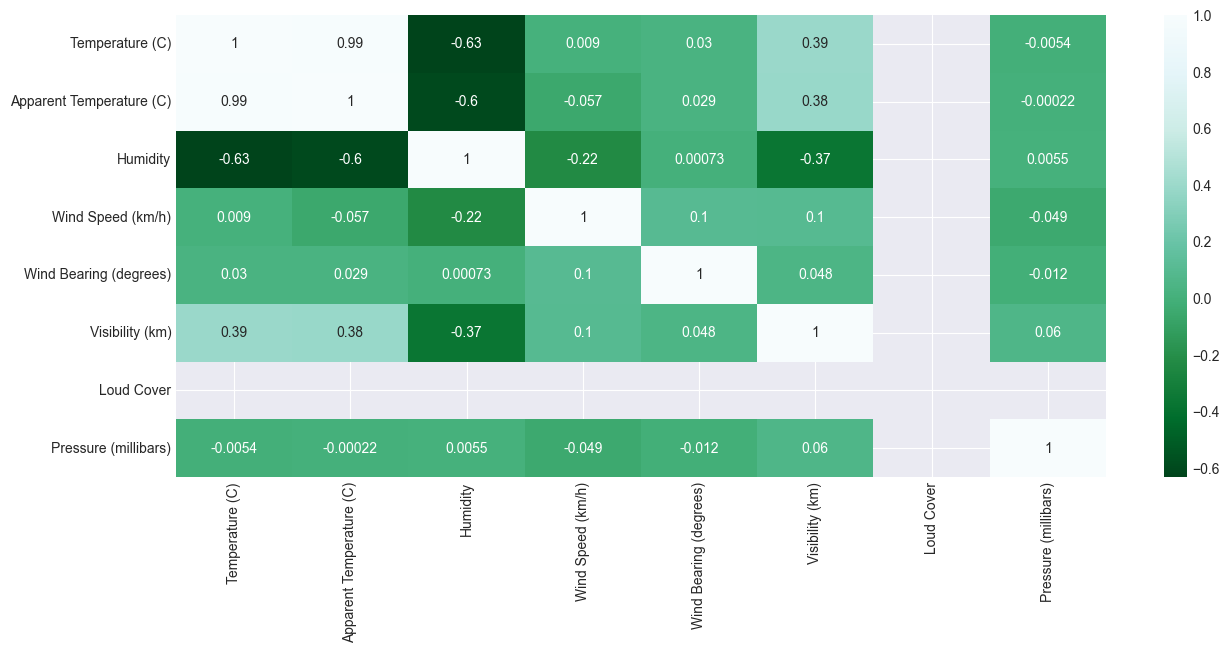

In [16]:
sns.heatmap(data_df[num_cols].corr() , annot= True , cmap='BuGn_r') #terrain_r


In [17]:
temp_df = data_df[['datetime' , 'Temperature (C)']]
temp_df = temp_df.sort_values('datetime' , axis=0 , ascending= True)
temp_df = temp_df.reset_index(drop= True)
temp_df.head()

,datetime,Temperature (C)
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [18]:
temp_df = temp_df.rename({'Temperature (C)' : 'temp'}, axis = 1)

<Axes: xlabel='datetime'>

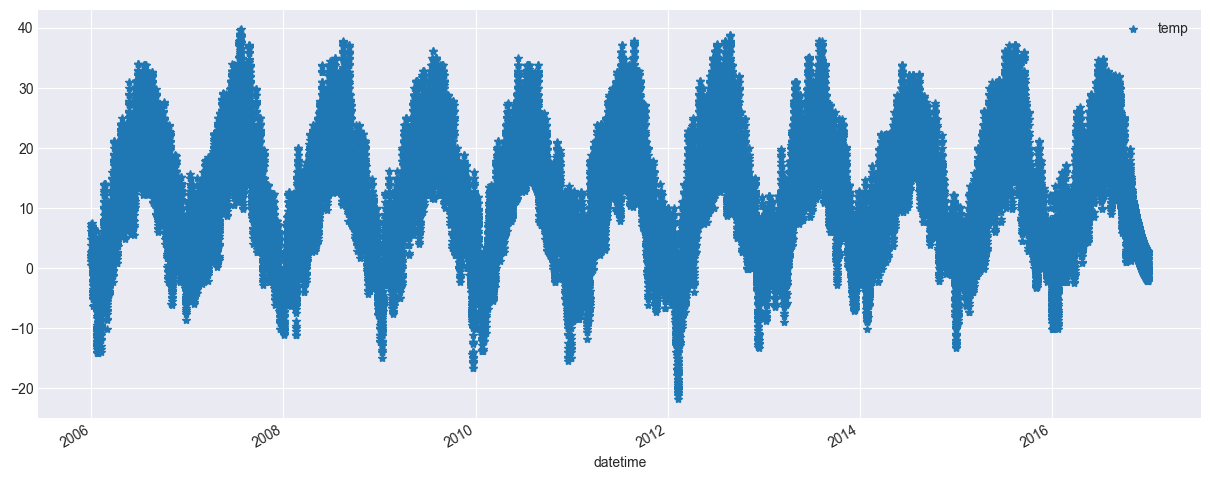

In [19]:
temp_df.plot(x = 'datetime' , y = 'temp' , style= '*')

In [20]:
h_units = 100
input_shape = (1,10000)

model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(units= h_units ,  activation= 'tanh' , 
                                    input_shape = input_shape))

model.add(tf.keras.layers.Dense(1 , activation ='linear'))

In [21]:
wax = model.get_weights()[0].shape
waa = model.get_weights()[1].shape
baa = model.get_weights()[2].shape
way = model.get_weights()[3].shape
bay = model.get_weights()[4].shape

wax , waa , baa , way , bay

((10000, 100), (100, 100), (100,), (100, 1), (1,))

In [22]:
temp_df.head(30)

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333
5,2006-01-01 04:00:00+00:00,1.205556
6,2006-01-01 05:00:00+00:00,2.222222
7,2006-01-01 06:00:00+00:00,2.072222
8,2006-01-01 07:00:00+00:00,2.200000
9,2006-01-01 08:00:00+00:00,2.733333


In [23]:
time_step = 24

y_idx = np.arange(time_step , temp_df.shape[0] , time_step)
y_idx.shape



(4018,)

In [24]:
y_df = temp_df.iloc[y_idx]
y_df.head()

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556


In [25]:
y_df.shape[0]*time_step

96432

In [26]:
X_df = temp_df.iloc[range(len(y_df)*time_step)]
X_df.shape


(96432, 2)

In [27]:
X = np.reshape(X_df['temp'].to_numpy() ,
              (y_df.shape[0] , time_step))
X = X[: , :23]
X.shape

(4018, 23)

Input shape expected = '[batch , timesteps , feature]'

In [28]:
X = np.reshape(X , (X.shape[0] , X.shape[1] , 1))
X.shape

(4018, 23, 1)

In [29]:
split = int(y_df.shape[0]*(1-TEST_SIZE))
X_train = X[:split]
X_test = X[split:]

y_train =y_df['temp'].to_numpy()[:split]
y_test =y_df['temp'].to_numpy()[split:]

X_train.shape, X_test.shape , y_train.shape , y_test.shape


((3214, 23, 1), (804, 23, 1), (3214,), (804,))

In [30]:
h_units = 256
input_shape = (time_step -1 , 1)

model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(units= h_units ,  activation= 'tanh' , 
                                    input_shape = input_shape))

model.add(tf.keras.layers.Dense(1 , activation ='linear'))

model.compile(loss =  'mean_squared_error' , metrics= [tf.keras.metrics.RootMeanSquaredError()] ,
              optimizer = 'adam')

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 256)               66048     
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 66305 (259.00 KB)
Trainable params: 66305 (259.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
history = model.fit(X_train,y_train,
                    validation_data=(X_test,y_test),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=2)

Epoch 1/20

101/101 - 4s - loss: 12.3271 - root_mean_squared_error: 3.5110 - val_loss: 1.0554 - val_root_mean_squared_error: 1.0273 - 4s/epoch - 37ms/step
Epoch 2/20
101/101 - 2s - loss: 1.9432 - root_mean_squared_error: 1.3940 - val_loss: 0.9812 - val_root_mean_squared_error: 0.9906 - 2s/epoch - 18ms/step
Epoch 3/20
101/101 - 2s - loss: 1.3992 - root_mean_squared_error: 1.1829 - val_loss: 0.7877 - val_root_mean_squared_error: 0.8876 - 2s/epoch - 19ms/step
Epoch 4/20
101/101 - 2s - loss: 1.4301 - root_mean_squared_error: 1.1959 - val_loss: 0.8907 - val_root_mean_squared_error: 0.9437 - 2s/epoch - 16ms/step
Epoch 5/20
101/101 - 2s - loss: 1.2149 - root_mean_squared_error: 1.1022 - val_loss: 0.7502 - val_root_mean_squared_error: 0.8662 - 2s/epoch - 15ms/step
Epoch 6/20
101/101 - 2s - loss: 1.1643 - root_mean_squared_error: 1.0790 - val_loss: 0.8320 - val_root_mean_squared_error: 0.9121 - 2s/epoch - 17ms/step
Epoch 7/20
101/101 - 2s - loss: 1.1229 - root_mean_squared_error: 1.0597 - val_l

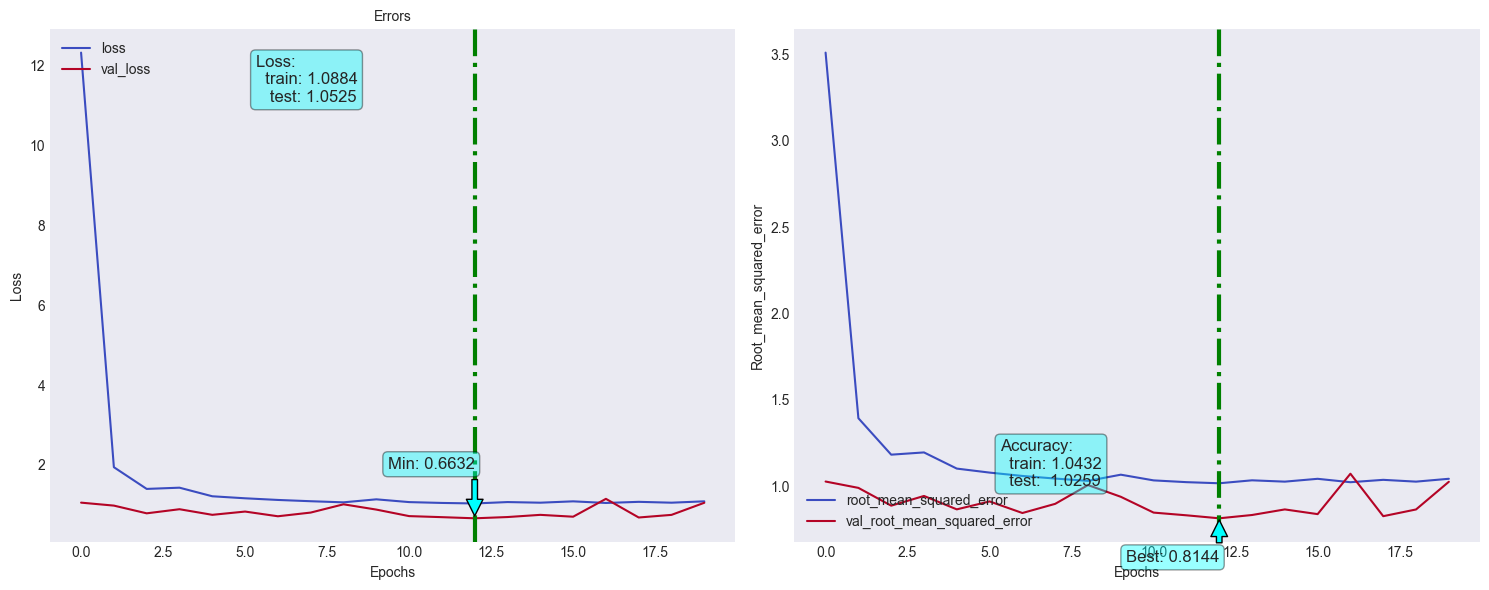

In [33]:
fn_plot_tf_hist(pd.DataFrame(history.history))

In [34]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred = np.append(y_train_pred , y_test_pred)
y_pred.shape

26/26 [==============================] - 0s 6ms/step


(4018,)

In [35]:
res_df = y_df.copy()
res_df['pred'] = y_pred
res_df['datetime'] = res_df['datetime'].dt.date
res_df.head()

,datetime,temp,pred
24,2006-01-01,5.422222,4.408096
48,2006-01-02,1.694444,1.256865
72,2006-01-03,2.200000,1.447130
96,2006-01-04,1.666667,1.393898
120,2006-01-05,1.805556,1.938519


‘Accent’, ‘Accent_r’, ‘Blues’, ‘Blues_r’, ‘BrBG’, ‘BrBG_r’, ‘BuGn’, ‘BuGn_r’, ‘BuPu’, ‘BuPu_r’, ‘CMRmap’, ‘CMRmap_r’, ‘Dark2’, ‘Dark2_r’, ‘GnBu’, ‘GnBu_r’,  ‘Greens’, ‘Greens_r’, ‘Greys’, ‘Greys_r’, ‘OrRd’, ‘OrRd_r’, ‘Oranges’, ‘Oranges_r’,  ‘PRGn’, ‘PRGn_r’, ‘Paired’, ‘Paired_r’, ‘Pastel1’, ‘Pastel1_r’, ‘Pastel2’,  ‘Pastel2_r’, ‘PiYG’, ‘PiYG_r’, ‘PuBu’, ‘PuBuGn’, ‘PuBuGn_r’, ‘PuBu_r’, ‘PuOr’, ‘PuOr_r’, ‘PuRd’, ‘PuRd_r’, ‘Purples’, ‘Purples_r’, ‘RdBu’, ‘RdBu_r’, ‘RdGy’, ‘RdGy_r’, ‘RdPu’, ‘RdPu_r’, ‘RdYlBu’, ‘RdYlBu_r’, ‘RdYlGn’, ‘RdYlGn_r’, ‘Reds’, ‘Reds_r’, ‘Set1’, ‘Set1_r’, ‘Set2’, ‘Set2_r’, ‘Set3’, ‘Set3_r’, ‘Spectral’, ‘Spectral_r’, ‘Wistia’, ‘Wistia_r’, ‘YlGn’, ‘YlGnBu’, ‘YlGnBu_r’, ‘YlGn_r’, ‘YlOrBr’, ‘YlOrBr_r’, ‘YlOrRd’, ‘YlOrRd_r’, ‘afmhot’, ‘afmhot_r’, ‘autumn’, ‘autumn_r’, ‘binary’, ‘binary_r’,  ‘bone’, ‘bone_r’, ‘brg’, ‘brg_r’, ‘bwr’, ‘bwr_r’, ‘cividis’, ‘cividis_r’, ‘cool’, ‘cool_r’,  ‘coolwarm’, ‘coolwarm_r’, ‘copper’, ‘copper_r’, ‘cubehelix’, ‘cubehelix_r’, ‘flag’, ‘flag_r’,  ‘gist_earth’, ‘gist_earth_r’, ‘gist_gray’, ‘gist_gray_r’, ‘gist_heat’, ‘gist_heat_r’, ‘gist_ncar’,  ‘gist_ncar_r’, ‘gist_rainbow’, ‘gist_rainbow_r’, ‘gist_stern’, ‘gist_stern_r’, ‘gist_yarg’,  ‘gist_yarg_r’, ‘gnuplot’, ‘gnuplot2’, ‘gnuplot2_r’, ‘gnuplot_r’, ‘gray’, ‘gray_r’, ‘hot’, ‘hot_r’,  ‘hsv’, ‘hsv_r’, ‘icefire’, ‘icefire_r’, ‘inferno’, ‘inferno_r’, ‘jet’, ‘jet_r’, ‘magma’, ‘magma_r’,  ‘mako’, ‘mako_r’, ‘nipy_spectral’, ‘nipy_spectral_r’, ‘ocean’, ‘ocean_r’, ‘pink’, ‘pink_r’,  ‘plasma’, ‘plasma_r’, ‘prism’, ‘prism_r’, ‘rainbow’, ‘rainbow_r’, ‘rocket’, ‘rocket_r’,  ‘seismic’, ‘seismic_r’, ‘spring’, ‘spring_r’, ‘summer’, ‘summer_r’, ‘tab10’, ‘tab10_r’,’tab20′, ‘tab20_r’, ‘tab20b’, ‘tab20b_r’, ‘tab20c’, ‘tab20c_r’, ‘terrain’, ‘terrain_r’, ‘turbo’,  ‘turbo_r’, ‘twilight’, ‘twilight_r’, ‘twilight_shifted’, ‘twilight_shifted_r’, ‘viridis’,  ‘viridis_r’, ‘vlag’, ‘vlag_r’, ‘winter’, ‘winter_r’

<Axes: xlabel='datetime'>

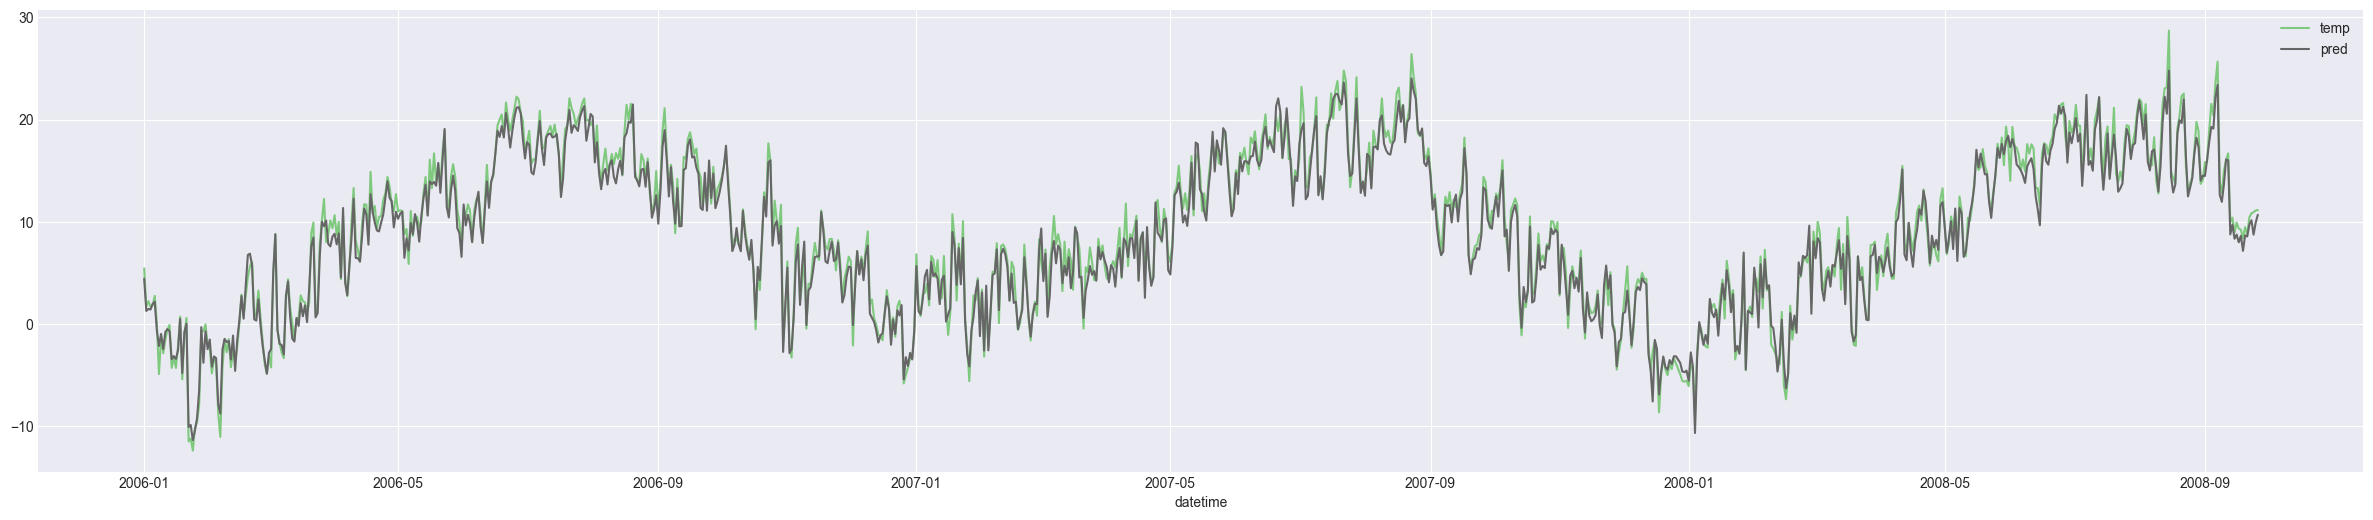

In [55]:
fig , ax = plt.subplots(figsize = (30,6))
res_df[:1000].plot(x ='datetime',y=['temp','pred'] , ax =ax , colormap='Accent')

<Axes: xlabel='datetime'>

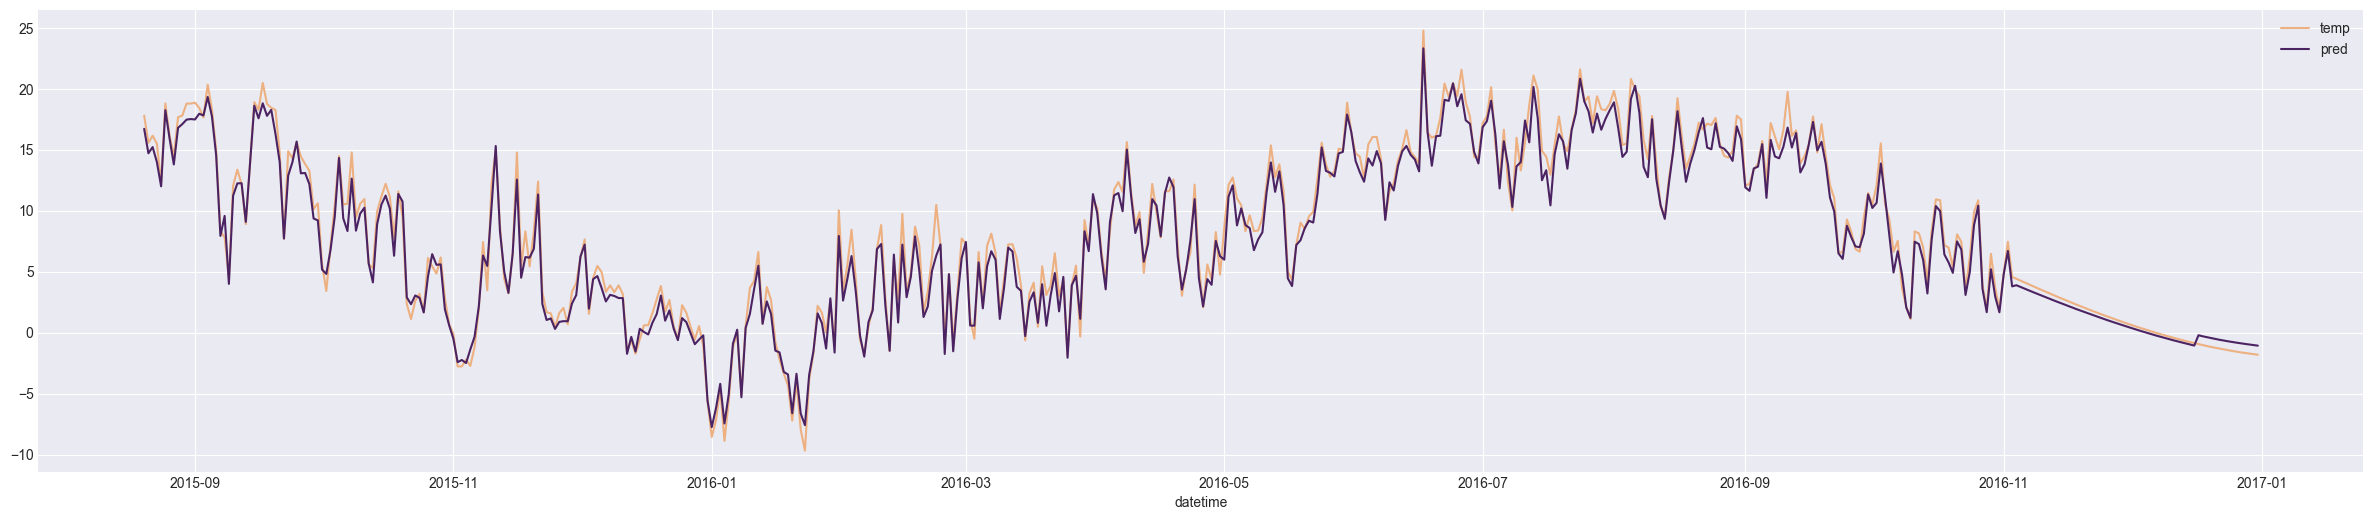

In [48]:
fig , ax = plt.subplots(figsize = (30,6))
res_df[-500:].plot(x ='datetime',y=['temp','pred'] , ax =ax , colormap='flare')

In [59]:
tmp_df = data_df[['datetime' , 'Temperature (C)' ,'Humidity' , 'Visibility (km)']]
tmp_df = tmp_df.sort_values('datetime' , axis=0 , ascending= True)
tmp_df = tmp_df.reset_index(drop= True)
tmp_df.head()

,datetime,Temperature (C),Humidity,Visibility (km)
0,2005-12-31 23:00:00+00:00,0.577778,0.89,9.9820
1,2006-01-01 00:00:00+00:00,1.161111,0.85,9.9015
2,2006-01-01 01:00:00+00:00,1.666667,0.82,9.9015
3,2006-01-01 02:00:00+00:00,1.711111,0.82,9.9015
4,2006-01-01 03:00:00+00:00,1.183333,0.86,9.9015


<Axes: xlabel='datetime'>

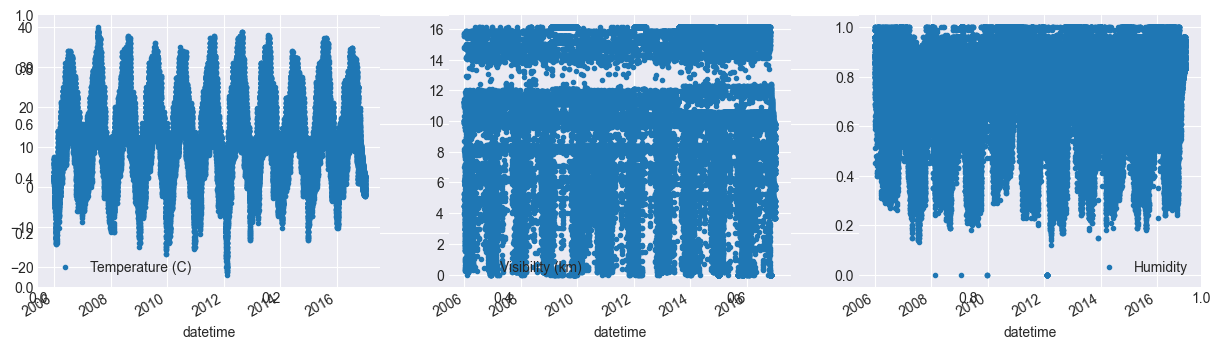

In [61]:
fig , ax = plt.subplots(figsize = (15,4))
ax = fig.add_subplot(1,3,1)
tmp_df.plot(x = 'datetime' , y = 'Temperature (C)' , style='.' , ax=ax)

ax = fig.add_subplot(1,3,2)
tmp_df.plot(x = 'datetime' , y = 'Visibility (km)' , style='.' , ax=ax)

ax = fig.add_subplot(1,3,3)
tmp_df.plot(x = 'datetime' , y = 'Humidity' , style='.' , ax=ax)

In [65]:
time_step = 24

y_idx = np.arange(time_step , tmp_df.shape[0] , time_step)
y_idx.shape

y_df = tmp_df.iloc[y_idx][['datetime','Temperature (C)']]
y_df.head()

,datetime,Temperature (C)
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556


In [66]:
X_df = tmp_df.iloc[range(len(y_df)*time_step)]
X_df.shape


(96432, 4)

In [68]:
X_temp = np.reshape(X_df['Temperature (C)'].to_numpy() ,
              (y_df.shape[0] , time_step))
X_hum = np.reshape(X_df['Humidity'].to_numpy() ,
              (y_df.shape[0] , time_step))
X_vis = np.reshape(X_df['Visibility (km)'].to_numpy() ,
              (y_df.shape[0] , time_step))

In [71]:
X_temp = X_temp[: , :23]
X_hum = X_hum[: , :23]
X_vis = X_vis[: , :23]
X_temp.shape ,X_hum.shape ,X_vis.shape

((4018, 23), (4018, 23), (4018, 23))

In [73]:

X_data = np.stack( (X_temp,X_hum) ,axis= 2)
X_data.shape

(4018, 23, 2)

In [75]:
split = int(y_df.shape[0]*(1-TEST_SIZE))
X_train = X_data[:split]
X_test = X_data[split:]
y_train =y_df['Temperature (C)'].to_numpy()[:split]
y_test =y_df['Temperature (C)'].to_numpy()[split:]

X_train.shape, X_test.shape , y_train.shape , y_test.shape

((3214, 23, 2), (804, 23, 2), (3214,), (804,))

In [76]:

h_units = 256
input_shape = (time_step -1 , X_train.shape[2])

model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(units= h_units ,  activation= 'tanh' , 
                                    input_shape = input_shape))

model.add(tf.keras.layers.Dense(1 , activation ='linear'))

model.compile(loss =  'mean_squared_error' , metrics= [tf.keras.metrics.RootMeanSquaredError()] ,
              optimizer = 'adam')

In [77]:
history = model.fit(X_train,y_train,
                    validation_data=(X_test,y_test),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=2)

Epoch 1/20
101/101 - 3s - loss: 12.2176 - root_mean_squared_error: 3.4954 - val_loss: 1.3760 - val_root_mean_squared_error: 1.1730 - 3s/epoch - 33ms/step
Epoch 2/20
101/101 - 2s - loss: 1.8729 - root_mean_squared_error: 1.3686 - val_loss: 0.9089 - val_root_mean_squared_error: 0.9534 - 2s/epoch - 15ms/step
Epoch 3/20
101/101 - 2s - loss: 1.3773 - root_mean_squared_error: 1.1736 - val_loss: 0.8520 - val_root_mean_squared_error: 0.9230 - 2s/epoch - 15ms/step
Epoch 4/20
101/101 - 2s - loss: 1.2685 - root_mean_squared_error: 1.1263 - val_loss: 0.8426 - val_root_mean_squared_error: 0.9180 - 2s/epoch - 16ms/step
Epoch 5/20
101/101 - 2s - loss: 1.1679 - root_mean_squared_error: 1.0807 - val_loss: 0.7701 - val_root_mean_squared_error: 0.8776 - 2s/epoch - 17ms/step
Epoch 6/20
101/101 - 2s - loss: 1.3870 - root_mean_squared_error: 1.1777 - val_loss: 1.0110 - val_root_mean_squared_error: 1.0055 - 2s/epoch - 16ms/step
Epoch 7/20
101/101 - 2s - loss: 1.1661 - root_mean_squared_error: 1.0799 - val_lo

In [78]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,12.217582,3.495366,1.375969,1.173017
1,1.872933,1.368551,0.908922,0.953374
2,1.377281,1.173576,0.852006,0.923042
3,1.268485,1.126270,0.842633,0.917950
4,1.167923,1.080705,0.770149,0.877581


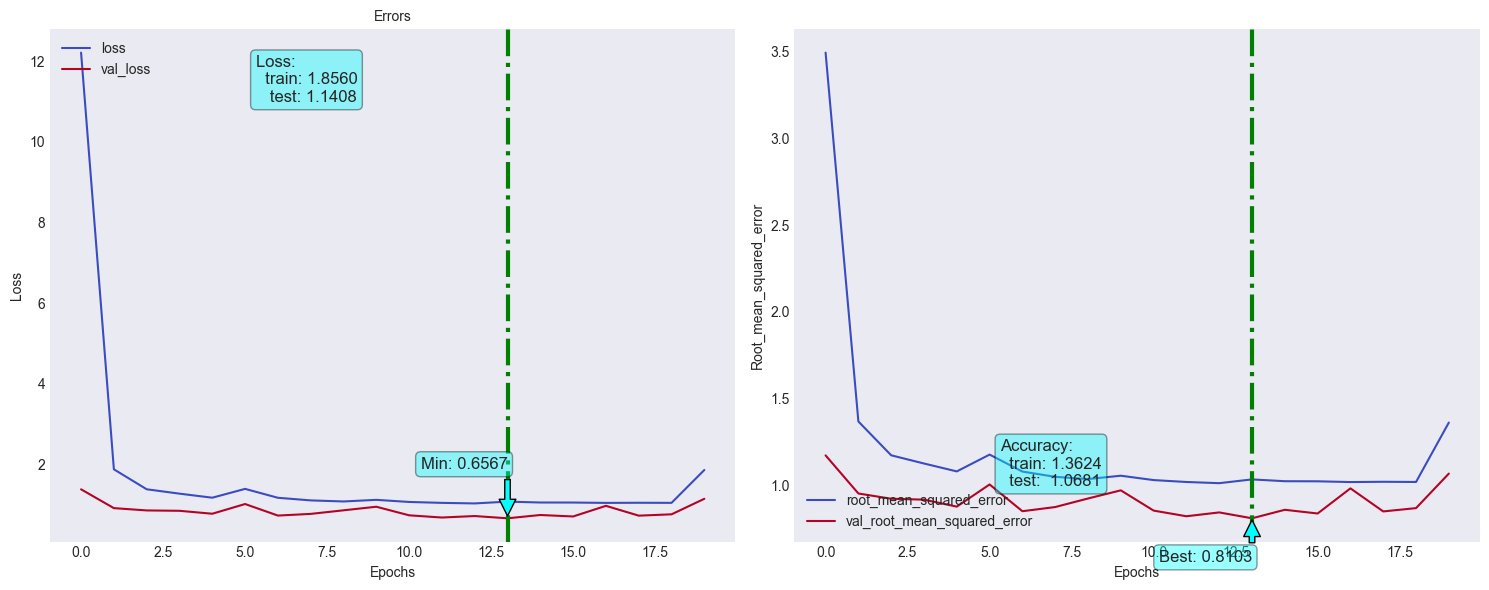

In [79]:
fn_plot_tf_hist(pd.DataFrame(history.history))


In [80]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred = np.append(y_train_pred , y_test_pred)
y_pred.shape

26/26 [==============================] - 0s 7ms/step


(4018,)

In [81]:
res_df = y_df.copy()
res_df['pred'] = y_pred
res_df['datetime'] = res_df['datetime'].dt.date
res_df.head()

,datetime,Temperature (C),pred
24,2006-01-01,5.422222,4.574726
48,2006-01-02,1.694444,1.052139
72,2006-01-03,2.200000,2.320412
96,2006-01-04,1.666667,1.158324
120,2006-01-05,1.805556,1.838996


<Axes: xlabel='datetime'>

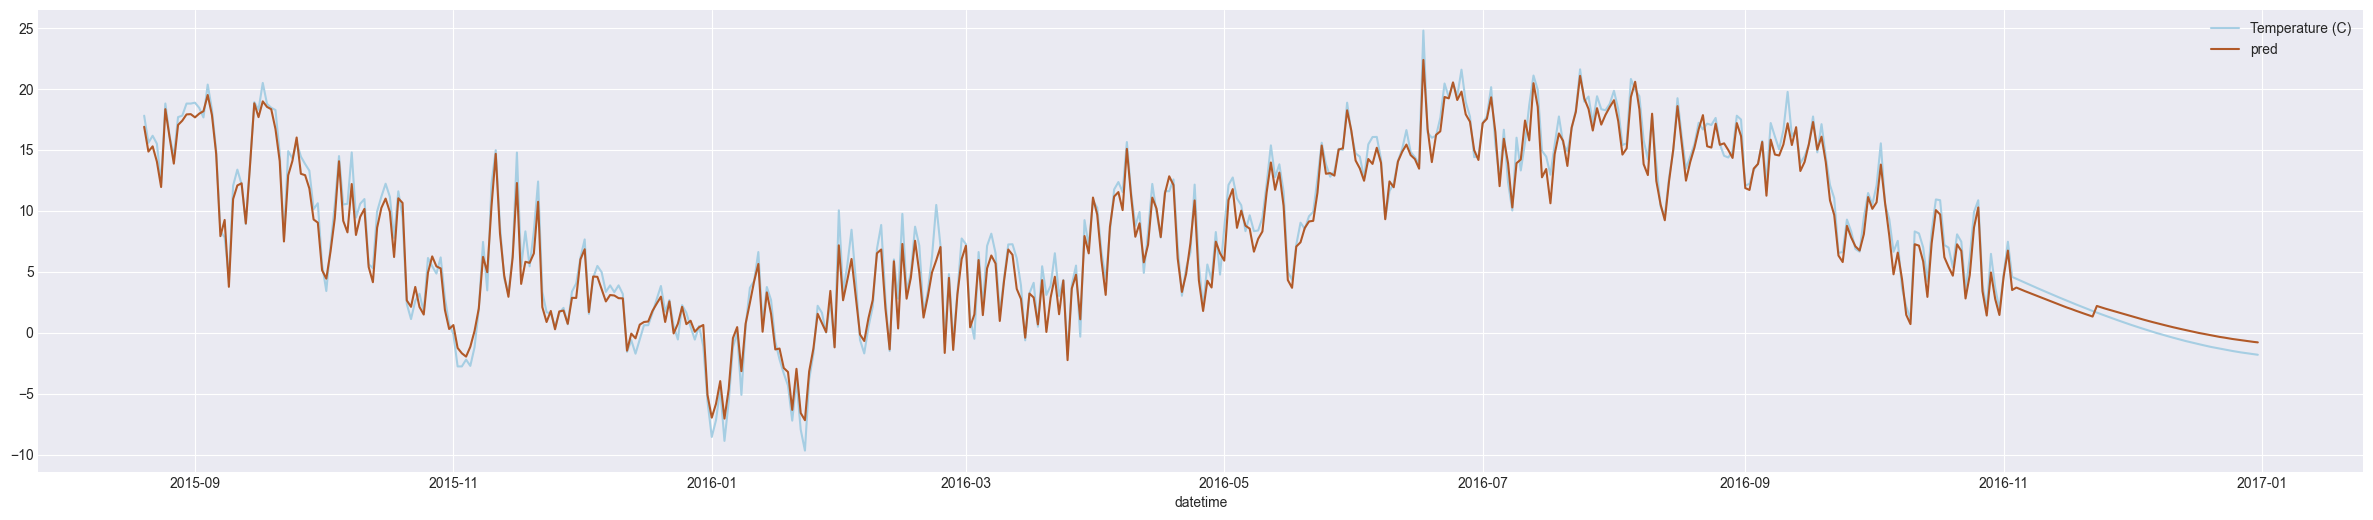

In [88]:
fig , ax = plt.subplots(figsize = (30,6))
res_df[-500:].plot(x ='datetime',y=['Temperature (C)','pred'] , ax =ax , colormap='Paired')